# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [2]:
!pip install transformers
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


2. Load the data from the hub.

In [4]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/fine-tuning-instruct-aira", split="aira_instruct_english")

df = dataset.to_pandas()

display(df)

prompt  \
0               Which is a species of fish? Tope or Rope   
1         Why can camels survive for long without water?   
2      Alice's parents have three daughters: Amy, Jes...   
3       Who gave the UN the land in NY to build their HQ   
4                            Why mobile is bad for human   
...                                                  ...   
53129  How do computers communicate and network with ...   
53130  How are websites different from web applications?   
53131     What is open-source software and its benefits?   
53132  What is a cookie and how is it used in web bro...   
53133  What is cloud storage and its advantages for d...   

                                              completion  
0                                                   Tope  
1      Camels use the fat in their humps to keep them...  
2                The name of the third daughter is Alice  
3                                    John D Rockerfeller  
4      We are always engaged one phone which is not g...  
...                                                  ...  
53129  Computers communicate and network with each ot...  
53130  Websites and web applications are similar in t...  
53131  Open-source software is software that is made ...  
53132  A cookie is a small piece of data that a websi...  
53133  Cloud storage is a service that allows you to ...  

[53134 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [5]:
from transformers import GPT2Tokenizer

model = "gpt2-large" # "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "pierreguillou/gpt2-small-portuguese"
model_size = "774M" # "124M", "355M", "774M", and "1.5B", "PT-124M"

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  53134
The longest demonstration is 300 tokens long.


6. Create the Dataset class.

In [6]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, gpt2_type="gpt2", max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [7]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 47,820
Number of validation samples: 5,314


8. Create the `DataLoaders` and specify the `batch_size`.

In [8]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=8 # 32, 20, 8, 8
        )

# validation data loader doesn't need randomization
validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=8
        )

9. Load the base model (`GPT2LMHeadModel`).

In [9]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50259, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [12]:
UNFREEZE_LAST_N = 9 #6, 8, 9, 12

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  36
Number of transformer blocks to  un-freeze:  9
Number of frozen layers: 325
Number of trainable layers: 111


11. Set the training hyperparameters.

In [13]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 2 # 5, 3, 2, 1

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [14]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'./Aira-{model_size}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 2



  7%|▋         | 400/5978 [04:38<1:04:12,  1.45it/s]


Batch 400 of 5978. Loss:0.6028859615325928.


Example output: What is the most secure way to store financial information.The most secure way to store financial information is to have a financial agency that is able to provide secure storage, including cold storage, with a combination of various cryptographic principles.



 13%|█▎        | 800/5978 [09:17<59:35,  1.45it/s]


Batch 800 of 5978. Loss:0.6626878380775452.


Example output: Can you give me advice on setting up a business.One of the best ways to set up a business is to create an account with a reputable financial institution. Start by researching the account you need, and you should be able to find a reliable and trustworthy account to start with. Additionally, look for services that are offered specifically for businesses or professionals and make sure to compare rates. This can help you find a comfortable level of cost for each service. Finally, make sure you have a plan for growth. Research the business and find out the resources and marketing campaigns that can help you reach your desired audience.



 20%|██        | 1200/5978 [13:58<54:59,  1.45it/s]


Batch 1200 of 5978. Loss:0.655192494392395.



 20%|██        | 1201/5978 [14:01<1:39:26,  1.25s/it]


Example output: Please help me find an interesting but classic book to read for my commute this week.One interesting book to read for your commute this week is "The Hitchhiker's Guide to the Galaxy" by Douglas Adams. It is a classic fantasy adventure book that follows the protagonist's journey to save the universe.



 27%|██▋       | 1600/5978 [18:37<50:23,  1.45it/s]


Batch 1600 of 5978. Loss:0.7218917012214661.



 27%|██▋       | 1601/5978 [18:38<1:11:20,  1.02it/s]


Example output: Name five different cheeses.Tequila, Chorizo, Mashed Potatoes, Burgundy Cheese, and Mashed Potatoes



 33%|███▎      | 2000/5978 [23:14<45:47,  1.45it/s]


Batch 2000 of 5978. Loss:0.4903753697872162.


Example output: What is algebra and who invented it?Algebra and the foundations of mathematics are incredibly complex and require a lot of practice in order to learn. The concepts of algebra and the algebraic equations are based on equations and sequences of equations, not on purely numerical information. It is important to differentiate between algorithms and algorithms' algorithms, as Algebra and the Algebraic equations work very effectively in situations where these equations are being used to solve complex problems. For instance, using the equation A=1 and applying it to any real number, such as 1, can solve any equation of that order. The equations of motion are typically solvable by algebraic equations and have some applications in machine learning, where it is possible to identify patterns in data that are difficult to solve with numerical information.



 40%|████      | 2400/5978 [27:56<41:11,  1.45it/s]


Batch 2400 of 5978. Loss:0.4223511219024658.


Example output: How can I improve my learning habits, so that the material I'm studying is stored in my memory more effectively.One of the most effective ways to improve your learning habits is to set small achievable goals. Break down your learning into smaller chunks and focus on mastering the material you are learning. This will help to stay motivated to study and make progress. Additionally, make sure to practice with native materials to help develop your understanding of the language and familiarize yourself with what you are learning. Finally, look for resources like books, podcasts, and websites that are designed to be visual and engaging, allowing you to experience the language from different angles and perspectives.



 47%|████▋     | 2800/5978 [32:37<36:35,  1.45it/s]


Batch 2800 of 5978. Loss:0.7402357459068298.


Example output: What is neoliberalism and what are its key tenets?Foliberalism is an ideology that emphasizes the importance of individual freedom and autonomy, while recognizing the importance of developing policies and technologies that guarantee social, economic, and political stability. It is often associated with economic deregulation, deregulation of industries and industries on a large scale, deregulation of industries within governments, deregulation of industries within state and local governments, and deregulation of industries within global companies. This ideology involves preserving individual freedom and autonomy, while encouraging technological advancements and exploring the world around us. It is often associated with the deregulation of the economy and the deregulation of the economy in general, as well as deregulation of government services and the deregulation of government and industries. Neoliberalism also involves th

 54%|█████▎    | 3200/5978 [37:21<31:58,  1.45it/s]


Batch 3200 of 5978. Loss:0.5701470971107483.


Example output: Write a brief paragraph of the benefits of attending Arizona State UniversityArizona State University is one of the oldest universities in the United States, dating back to 1867. It is a private institution with over 200 degree programs. It is also one of the best universities in the United States for those with a degree or master's degree in mathematics, economics, research science, public health, or education. Arizona State University offers its students a wide range of program offerings, including the renowned Stanford University University, University of Southern California, Arizona State University, Arizona State University, Arizona State University. Arizona State University offers its students a wide range of program offerings, including the renowned Stanford University University, University of Southern California, Arizona State University, Arizona State University, Arizona State University. Phoenix and Arizona are 

 60%|██████    | 3600/5978 [42:05<27:21,  1.45it/s]


Batch 3600 of 5978. Loss:0.7429184913635254.


Example output: How do I organize my home office.To organize your home office, you will need to find a storage space, decide what items you need and determine what you will get in exchange. Then, decide what features you want the office to have such as a filing system, tools, and materials. After that, you can decide if you want to keep everything in the closet or invest in some organizers. Once you have your space organized, you can start by sorting the items by type. This will help make use of the space better, such as organizing small items like the necessary items like coffee and paper. Finally, you can set realistic goals for the items you want and determine how much you need each one.



 67%|██████▋   | 4000/5978 [46:47<22:45,  1.45it/s]


Batch 4000 of 5978. Loss:0.7125013470649719.


Example output: Is violence good sometimes?As a manager, what is good for you is not always good for you, and what is bad sometimes is not necessarily bad in the long run. This could apply to conflicts or disputes, relationships with others or time in the workplace. It's important to acknowledge that it's okay to be willing to take some calculated risk or involve yourself in an argument to reach a resolution or finding a mutually beneficial solution. It's okay to be willing to try different strategies and to be open to finding ways to avoid conflict. It's also important to try to prioritize finding a productive solution and finding ways to communicate better and compromise when needed.



 74%|███████▎  | 4400/5978 [51:29<18:09,  1.45it/s]


Batch 4400 of 5978. Loss:0.9460142850875854.



 74%|███████▎  | 4401/5978 [51:31<27:22,  1.04s/it]


Example output: Classify each item as being at a playground or a gym: slide, swing, dumbbell, squat rack, seesawSlide: playground
Swing: Gym
Dumbbell: Gym
Squat Rack: Gym
Seesaw: Gym



 80%|████████  | 4800/5978 [56:06<13:33,  1.45it/s]


Batch 4800 of 5978. Loss:0.8724031448364258.


Example output: What are some useful strategies for solving a Rubik's cube.Crackers 
2. Turn the cube clockwise by moving one of the bottom pieces clockwise. 
3. Turn the cube clockwise by moving one of the bottom pieces clockwise. 
4. Turn the cube clockwise by moving one of the bottom pieces clockwise. 
5. Turn the cube clockwise by moving one of the bottom pieces clockwise. 
6. Turn the cube clockwise by moving one of the bottom pieces clockwise. 
7. Turn the cube clockwise by moving one of the bottom pieces clockwise. 
8. Turn the cube clockwise by moving one of the bottom pieces clockwise. 
9. Turn the cube clockwise by moving one of the bottom pieces clockwise. 
10 Turn the cube clockwise by moving one of the bottom pieces clockwise.



 87%|████████▋ | 5200/5978 [1:00:50<08:57,  1.45it/s]


Batch 5200 of 5978. Loss:0.5923346281051636.


Example output: How much should I save each month to purchase a house in five years.The amount you should save each month to purchase a house in five years will vary based on the size of your home, as well as the condition of the property and the financial commitment you need to commit. However, you may want to set a goal that limits the amount of time you need to save each month to purchase a house. Additionally, make sure to factor in any unexpected expenses you may incur, such as insurance or maintenance.



 94%|█████████▎| 5600/5978 [1:05:30<04:20,  1.45it/s]


Batch 5600 of 5978. Loss:0.5626195669174194.


Example output: I heard that meditation can be beneficial, do you know of any tips.Yes, regular meditation can be beneficial. Studies have found that regular physical activity can help keep the body moving and stay in shape. Regular physical activity can also help maintain a healthy diet and may also support other health benefits. Additionally, learning relaxation techniques such as deep breathing, progressive muscle relaxation, and progressive muscle relaxation (PMA) can help keep the body relaxed and focused on a task. Finally, talking to a friend or counselor can help create a supportive environment for regular meditation or other stress management techniques.



100%|██████████| 5978/5978 [1:09:55<00:00,  1.42it/s]



Average Training Loss: 0.6872660141050636.


Validation loss: 0.6161282828427795.


Beginning epoch 2 of 2



  7%|▋         | 400/5978 [04:36<1:04:12,  1.45it/s]


Batch 400 of 5978. Loss:0.3264784812927246.


Example output: What are the signs of an ingrown toenail.Common signs of an toenail toenail include pain when urinating, limited range of motion when urinating, and an urge to urinate when urinating. Other signs can include nausea, constipation, and tiredness.



 13%|█▎        | 800/5978 [09:14<59:36,  1.45it/s]


Batch 800 of 5978. Loss:0.560775876045227.


Example output: What is the best way to plan a vacation on a budget.The best way to plan a vacation on a budget is to compare prices across different sites, look for deals and discounts, and plan to have enough cash to make the most of your vacation. Additionally, consider budgeting for food, entertainment, and travel, and consider staying at a cheaper or better accommodation. Finally, if you need help staying within your budget, consider visiting a local local community center or community center with affordable or free activities or entertainment.



 20%|██        | 1200/5978 [13:54<54:58,  1.45it/s]


Batch 1200 of 5978. Loss:0.41560453176498413.


Example output: What is the easiest way to learn a language by myself.The easiest way to learn a language by yourself is to find a language learning program that offers tutorials and activities to help you learn the language. These programs usually provide comprehensive lessons, with examples and exercises to help you understand the language. Additionally, many provide virtual courses, which provide content and exercises in a more streamlined way than a tutorial.



 27%|██▋       | 1600/5978 [18:33<50:23,  1.45it/s]


Batch 1600 of 5978. Loss:0.35295894742012024.


Example output: What are some tips and tricks for mastering a computer game.Make sure to practice regularly - even if it’s only for a few minutes each day. 
2  Break down the game into manageable chunks and set achievable goals. 
3  Participate in team discussions and work together to solve problems.
4  Identify any issues you may have and delegate the tasks to the team.
5  Take breaks, and keep yourself motivated.
6  Take breaks from work to reward yourself.
7  Find a comfortable, quiet space and focus on learning the game.
8  Test yourself often to make sure you are having fun and enjoying the game.



 33%|███▎      | 2000/5978 [23:15<45:47,  1.45it/s]


Batch 2000 of 5978. Loss:0.5085460543632507.


Example output: What activities can I do with my family to stay active.Some activities you can do with your family to stay active include playing active video games, doing yoga, taking a nature walk, doing a workout, going for a hike, or biking. You can also watch a movie or read a book together, or listen to music.



 40%|████      | 2400/5978 [27:53<41:10,  1.45it/s]


Batch 2400 of 5978. Loss:0.458877831697464.


Example output: Which country has the best soccer team in the world.The answer to this will depend on who you ask. Some people may point to countries like Germany, Italy, or Spain as the best soccer teams to play in. Each has its own strengths and weaknesses and will create its own answer. For example, some people may point to Argentina as the best soccer team to play in because of their technical abilities, while others may point to Brazil as the best soccer team to play in based on their passion and passion for their sport. Ultimately, it really comes down to what you are looking for when evaluating a soccer team and who you are interested in playing with.



 47%|████▋     | 2800/5978 [32:35<36:34,  1.45it/s]


Batch 2800 of 5978. Loss:0.8314157724380493.



 47%|████▋     | 2801/5978 [32:36<48:37,  1.09it/s]


Example output: What are some words that rhyme with orangeorange, orange, orange, orange, orange, orange, orange, orange, orange



 54%|█████▎    | 3200/5978 [37:12<31:58,  1.45it/s]


Batch 3200 of 5978. Loss:0.5375759601593018.


Example output: What are some beginner tips for learning guitar.Start with simple songs such as 'Happy on Their Own' by Phish.
2. Learn chords and scales on guitar.
3. Practice and refine your technique.
4. Learn improvisation and practice scales and chords together.
5. Learn to play along with songs.
6. Learn to play along with songs written by other musicians.
7. Listen to recordings of professional guitarists.
8. Use online lessons and tutorials to learn the basics.
9. Play and enjoy playing guitar.



 60%|██████    | 3600/5978 [41:52<27:21,  1.45it/s]


Batch 3600 of 5978. Loss:0.5550445914268494.


Example output: I'm applying for a new job and need to know what to expect in an interview in my industry.In an interview for your industry, you should expect the interviewer to ask a variety of thoughtful questions to demonstrate that you understand and demonstrate your enthusiasm for the role. Additionally, it is important to be honest, clear, and respectful throughout the interview.



 67%|██████▋   | 4000/5978 [46:31<22:45,  1.45it/s]


Batch 4000 of 5978. Loss:0.33791348338127136.


Example output: What are the best YouTube channels for cooking tutorials.The best YouTube channels for cooking tutorials are those that provide step-by-step instructions for simple cooking projects. They usually focus on food basics like boiling, roasting, or grilling, and usually have tutorials on the basics of basic recipes. YouTube also has channels that offer cooking tutorials in a variety of cuisines, from traditional Chinese to West African. Additionally, YouTube has a wealth of cooking instructional materials ranging from video tutorials to infographics and much more. Good luck.



 74%|███████▎  | 4400/5978 [51:11<18:09,  1.45it/s]


Batch 4400 of 5978. Loss:0.47749656438827515.


Example output: Can you provide a recipe for making tomato soup.Ingredients:
- 3 cups diced onion
- 1 onion, diced
- 2 cloves garlic, minced
- 1 pound beef stew meat
- 1 teaspoon Worcestershire sauce
- 1 teaspoon dried basil
- 1 teaspoon dried thyme
- 1 teaspoon ground coriander
- 1/2 teaspoon paprika
- 1/2 teaspoon cumin
- 1/4 teaspoon garlic powder
- Salt and pepper, to taste

Instructions:
1. Heat a large pot over medium heat.
2. Add the onion, garlic, and beef. Cook until the beef is softened and the onion is fragrant, about 15 minutes.
3. Add the Worcestershire sauce and basil, and cook for 1 minute more.
4. Add the thyme, coriander, paprika, and cumin and cook for 1 minute more.
5. Stir in the soup broth



 80%|████████  | 4800/5978 [55:55<13:33,  1.45it/s]


Batch 4800 of 5978. Loss:0.4787990152835846.



 80%|████████  | 4801/5978 [55:57<23:44,  1.21s/it]


Example output: Can you explain updateless decision theory?UDT is a decision theory that aims to solve an issue present in decision-making theories, which is the need to consider the decision maker as a component of the environment in which the decisions are made.



 87%|████████▋ | 5200/5978 [1:00:33<08:57,  1.45it/s]


Batch 5200 of 5978. Loss:0.311775803565979.


Example output: I'm having trouble with algebra, can you help me solve this equation.I'm sorry, I'm not able to help you with algebra equations. First, let's look at some examples. Let's consider an equation with solutions to it. What is the equation y=x+2 and what is the second equation y=2+x? First, we need to know what is the x-coordinates of the two equations. Then we need to know the solutions for the first equation. Once we have all of this information, we can use algebra to solve the equation y=2+x.



 94%|█████████▎| 5600/5978 [1:05:13<04:20,  1.45it/s]


Batch 5600 of 5978. Loss:0.44621706008911133.



 94%|█████████▎| 5601/5978 [1:05:15<06:27,  1.03s/it]


Example output: Can you define data augmentation?Data Augmentation is a method that generates "fake samples" by modifying the training data to create synthetic instances of the true data.



100%|██████████| 5978/5978 [1:09:35<00:00,  1.43it/s]



Average Training Loss: 0.46858145299066306.


Validation loss: 0.5825508199688187.

Training complete!


('/content/drive/MyDrive/Colab Notebooks/Aira-774M/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-774M/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-774M/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-774M/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Aira-774M/added_tokens.json')

13. Check the training stats and plot the learning curves.

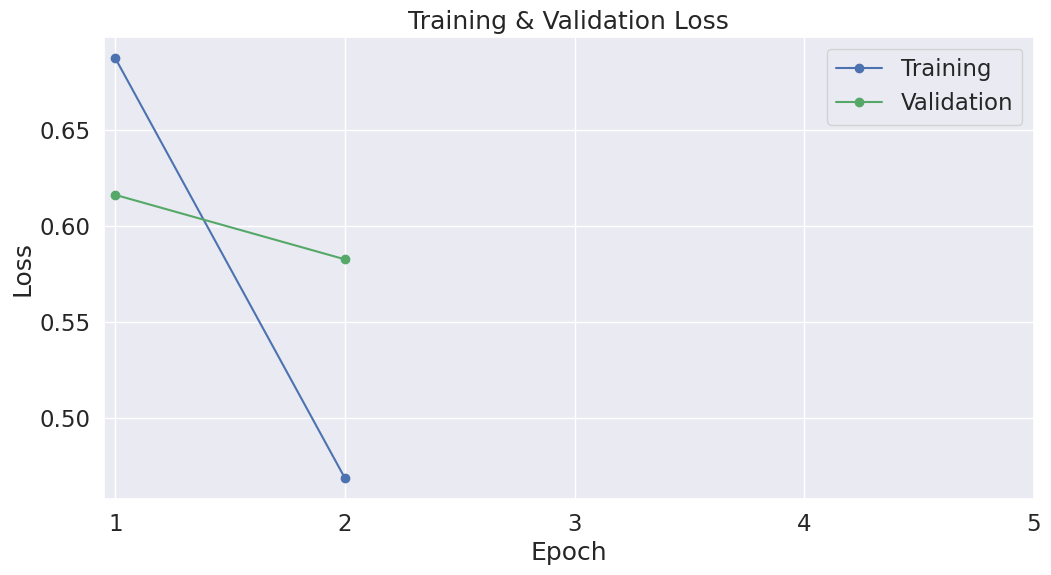

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

13. Load and test the model.

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(output_dir)
aira = AutoModelForCausalLM.from_pretrained(output_dir)

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    temperature=0.7,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    # print only the response and remove the question
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')


Enter your question: What is the capital of France?
Question: 👤 What is the capital of France?

Response 1: 🤖 The capital of France is Paris.
Response 2: 🤖 The capital of France is Paris.


Done! 🤗